In [2]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
#from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor
#from detectron2.evaluation import COCOEvaluator

# TRAINING
from detectron2.engine import DefaultTrainer

import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
# DATA_SET_NAME = dataset.name.replace(" ", "-")
# DATA_SET_LOCATION = dataset.location

# DATA_SET_NAME = "nodule-detection-origin-max-1"
# DATA_SET_LOCATION = "nodule-detection-origin-max-1"

DATA_SET_NAME = "detectron_aug_origin"
DATA_SET_LOCATION = "E:/LUNA/Autolabel/aug_origin_aug"
ANNOTATIONS_FILE_NAME = "_annotations_aug_origin_aug.json"

In [5]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATA_SET_LOCATION, "train/images")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(DATA_SET_LOCATION, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATA_SET_LOCATION, "test/images")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(DATA_SET_LOCATION, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(DATA_SET_LOCATION, "valid/images")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(DATA_SET_LOCATION, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

## Checking dataset & Visualize input

We can now confirm that our custom dataset was correctly registered using [MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [6]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['detectron_lung_aug-train',
 'detectron_lung_aug-test',
 'detectron_lung_aug-valid']


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



[0, 1]
{0: 0, 1: 1}
E:/LUNA/Autolabel/1126/yolo_lung_aug\train/images\0-(116)-[0]_0_1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.png


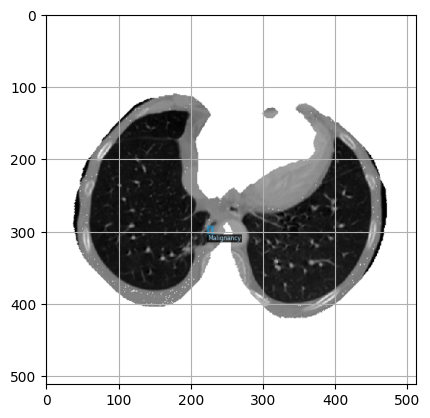

In [7]:
from  matplotlib import pyplot as plt
%matplotlib inline
#plt.rcParams["axes.grid"] = False



metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

#print(metadata)
for i in range(0, 60, 6):
    dataset_entry = dataset_train[i]
    image = cv2.imread(dataset_entry["file_name"])
    print(dataset_entry["file_name"])

    visualizer = Visualizer(
        image[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )

    out = visualizer.draw_dataset_dict(dataset_entry)
    im2 = out.get_image()[:, :, ::-1]
    plt.imshow(im2)
    plt.grid(None)
    plt.show()

## Train

In [8]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_R_101_FPN_3x"
# ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 380000
EVAL_PERIOD = 5000
BASE_LR = 0.00025  # 0.001
#BASE_LR = 0.001
NUM_CLASSES = 2

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)
#OUTPUT_DIR_PATH = "E:/LUNA/detectron2/detectron_origin_aug/faster_rcnn_R_101_FPN_3x/2023-11-30-19-28-02"

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

STAGE_CNT = 0

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)  # Let training initialize from model zoo
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
#cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
#cfg.DATASETS.VAL = (VALID_DATA_SET_NAME,)
cfg.DATASETS.TEST = (VALID_DATA_SET_NAME,)
#cfg.DATASETS.TEST = ()
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
#cfg.TEST.DETECTIONS_PER_IMAGE=2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR  # pick a good LR
cfg.SOLVER.MAX_ITER = MAX_ITER  # iterations
cfg.SEED = 42
# cfg.SOLVER.STEPS = []       # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.MODEL.DEVICE = str(device)


In [10]:
import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

class ConfusionMatrix:
    global STAGE_CNT
    # Updated version of https://github.com/kaanakan/object_detection_confusion_matrix
    def __init__(self, nc, conf=0.25, iou_thres=0.45):
        self.matrix = np.zeros((nc + 1, nc + 1))
        self.nc = nc  # number of classes
        self.conf = conf
        self.iou_thres = iou_thres

    def process_batch(self, detections, labels):#
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        '''prediction[coco_dt.anns[i]["score"]'''
        #print("process_batch: detections: ", detections)
        detections = torch.tensor(xywh2xyxy(detections))
        labels = torch.tensor(np.hstack((labels[:,0][:,None],xywh2xyxy(labels[:,1:]))))

        '''mark from yolov5'''

        detections = detections[detections[:, 4] > self.conf]
        gt_classes = labels[:, 0].int()
        detection_classes = detections[:, 5].int()
        iou = box_iou(labels[:, 1:], detections[:, :4])

        x = torch.where(iou > self.iou_thres)
        if x[0].shape[0]:
            '''0:gt_bbox_id  1:dt_bbox_id  2:iou'''
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]#np.unique除去重複
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        else:
            matches = np.zeros((0, 3))

        n = matches.shape[0] > 0
        m0, m1, _ = matches.transpose().astype(np.int16)
        for i, gc in enumerate(gt_classes):
            j = m0 == i
            if n and sum(j) == 1:
                self.matrix[detection_classes[m1[j]], gc] += 1  # correct
            else:
                self.matrix[self.nc, gc] += 1  # background FP

        if n:
            for i, dc in enumerate(detection_classes):
                if not any(m1 == i):
                    self.matrix[dc, self.nc] += 1  # background FN

    def matrix(self):
        return self.matrix

    def plot(self, normalize=True, save_dir='', names=(), rec_or_pred=0):#0=recall, 1=pred
        try:
            import seaborn as sn

            array = self.matrix / ((self.matrix.sum(rec_or_pred).reshape(1, -1) + 1E-6) if normalize else 1)  # normalize columns
            array[array < 0.0005] = 0.00 #np.nan  # don't annotate (would appear as 0.00)
            array = self.matrix + array

            fig = plt.figure(figsize=(8, 6), tight_layout=True)
            sn.set(font_scale=1.0 if self.nc < 50 else 0.8)  # for label size
            labels = (0 < len(names) < 99) and len(names) == self.nc  # apply names to ticklabels
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
                sn.heatmap(array, annot=self.nc < 30, annot_kws={"size": 8}, cmap='Blues', fmt='.2f', square=True,
                           xticklabels=names + ['background FP'] if labels else "auto",
                           yticklabels=names + ['background FN'] if labels else "auto").set_facecolor((1, 1, 1))
            fig.axes[0].set_xlabel('True')
            fig.axes[0].set_ylabel('Predicted')
            if rec_or_pred == 0:
                REC = sum([self.matrix[k, k] for k in range(self.nc)]) / sum(self.matrix.sum(rec_or_pred)[:-1])
                fig.suptitle("Recall (%.3f)"%REC)
            else:
                PRC = sum([self.matrix[k, k] for k in range(self.nc)]) / sum(self.matrix.sum(rec_or_pred)[:-1])
                fig.suptitle("Precision (%.3f)"%PRC)
            #plt.show()
            fig.savefig(save_dir, dpi=250)
            #plt.close()
            return REC, PRC, 2*REC*PRC/(REC+PRC)
        except Exception as e:
            print(f'WARNING: ConfusionMatrix plot failure: {e}')


    def print(self):
        # for i in range(self.nc + 1):
        #     print(' '.join(map(str, self.matrix[i])))
        REC = sum([self.matrix[k, k] for k in range(self.nc)]) / sum(self.matrix.sum(0)[:-1])
        PRC = sum([self.matrix[k, k] for k in range(self.nc)]) / sum(self.matrix.sum(1)[:-1])
        print("\nRecall: (%.4f)"%REC, "\nPrecision: (%.4f)"%PRC, "\nF1-score: (%.4f)" %(2 * REC * PRC / (REC + PRC)))



def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    #print("x: ", x)
    #print("y: ", y)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def process_batch(detections, labels, iouv):
    """
    Return correct predictions matrix. Both sets of boxes are in (x1, y1, x2, y2) format.
    Arguments:
        detections (Array[N, 6]), x1, y1, x2, y2, conf, class
        labels (Array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (Array[N, 10]), for 10 IoU levels
    """
    correct = torch.zeros(detections.shape[0], iouv.shape[0], dtype=torch.bool, device=iouv.device)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    x = torch.where((iou >= iouv[0]) & (labels[:, 0:1] == detections[:, 5]))  # IoU above threshold and classes match
    if x[0].shape[0]:
        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()  # [label, detection, iou]
        if x[0].shape[0] > 1:
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            # matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        matches = torch.Tensor(matches).to(iouv.device)
        correct[matches[:, 1].long()] = matches[:, 2:3] >= iouv
    return correct

def ap_per_class(tp, conf, pred_cls, target_cls, plot=False, save_dir='.', names=()):
    global STAGE_CNT
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:  True positives (nparray, nx1 or nx10).
        conf:  Objectness value from 0-1 (nparray).
        pred_cls:  Predicted object classes (nparray).
        target_cls:  True object classes (nparray).
        plot:  Plot precision-recall curve at mAP@0.5
        save_dir:  Plot save directory
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    px, py = np.linspace(0, 1, 1000), []  # for plotting
    ap, p, r = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = (target_cls == c).sum()  # number of labels
        n_p = i.sum()  # number of predictions

        if n_p == 0 or n_l == 0:
            continue
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum(0)
            tpc = tp[i].cumsum(0)

            # Recall
            recall = tpc / (n_l + 1e-16)  # recall curve
            r[ci] = np.interp(-px, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

            # Precision
            precision = tpc / (tpc + fpc)  # precision curve
            p[ci] = np.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

            # AP from recall-precision curve
            for j in range(tp.shape[1]):
                ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
                if plot and j == 0:
                    py.append(np.interp(px, mrec, mpre))  # precision at mAP@0.5

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + 1e-16)
    if plot:
        plot_pr_curve(px, py, ap, Path(save_dir) / (str(STAGE_CNT) + '_PR_curve.png'), names)
        plot_mc_curve(px, f1, Path(save_dir) / (str(STAGE_CNT) + '_F1_curve.png'), names, ylabel='F1')
        plot_mc_curve(px, p, Path(save_dir) / (str(STAGE_CNT) + '_P_curve.png'), names, ylabel='Precision')
        plot_mc_curve(px, r, Path(save_dir) / (str(STAGE_CNT) + '_R_curve.png'), names, ylabel='Recall')

    i = f1.mean(0).argmax()  # max F1 index
    return p[:, i], r[:, i], ap, f1[:, i], unique_classes.astype('int32')

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

def plot_pr_curve(px, py, ap, save_dir='pr_curve.png', names=()):
    # Precision-recall curve
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
    py = np.stack(py, axis=1)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth=1, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth=1, color='grey')  # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    fig.savefig(Path(save_dir), dpi=250)
    plt.close()


def plot_mc_curve(px, py, save_dir='mc_curve.png', names=(), xlabel='Confidence', ylabel='Metric'):
    # Metric-confidence curve
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f'{names[i]}')  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color='grey')  # plot(confidence, metric)

    y = py.mean(0)
    ax.plot(px, y, linewidth=3, color='blue', label=f'all classes {y.max():.2f} at {px[y.argmax()]:.3f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    fig.savefig(Path(save_dir), dpi=250)
    plt.close()

def plot_mc_pr_curve(detections, labels, save_dir, names):
    global STAGE_CNT
    detections = torch.tensor(xywh2xyxy(detections))
    labels = torch.tensor(np.hstack((labels[:, 0][:, None], xywh2xyxy(labels[:, 1:]))))
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    correct = process_batch(detections, labels, iouv)
    stats = []
    tcls = labels[:, 0].tolist()  # target class
    stats.append((correct.cpu(), detections[:, 4].cpu(), detections[:, 5].cpu(), tcls))
    # (correct, conf, pcls, tcls)
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, save_dir=save_dir, names=names)


In [11]:
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table

from detectron2.evaluation.evaluator import DatasetEvaluator


class COCOEvaluator(DatasetEvaluator):
    global STAGE_CNT
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.
    The metrics range from 0 to 100 (instead of 0 to 1), where a -1 or NaN means
    the metric cannot be computed (e.g. due to no predictions made).

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
        cfg_file=cfg ###additional
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file that can be loaded with `torch.load` and
                   contains all the results in the format they are produced by the model.
                2. "coco_instances_results.json" a json file in COCO's result format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl
        self._cfg_file = cfg_file##

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[COCOEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:#\\\\
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            assert task in {"bbox", "segm", "keypoints"}, f"Got unknown task: {task}!"
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                    cfg_file=self._cfg_file,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            print("============Per-category AP===========")
            '''per-category AP'''
            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            #print("\n\niou:",precisions.shape[0])=10
            precision = precisions[0, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP50"] * (N_COLS // 2),#AP
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP50-" + name: ap for name, ap in results_per_category})#AP
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)#t
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True,
        img_ids=None, cfg_file=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    global STAGE_CNT
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)

    #print("coco_results: ", coco_results)
    #print("coco_dt: ", coco_dt)
    #print("coco_gt: ", coco_gt)

    plot = True #(cfg_file != None) and (isinstance(cfg_file,CfgNode))
    #print("plot: ",plot)
    if plot:
        #from ..utils.confusion_matrix import ConfusionMatrix,xywh2xyxy,process_batch,ap_per_class
        C_M = ConfusionMatrix(nc=2, conf=0.65,iou_thres=0.3)
        stats = []
        #print("len(coco_gt.imgs): ", len(coco_gt.imgs))
        for i in range(len(coco_gt.imgs)):
            bbox_gt = np.array([y['bbox'] for y in coco_gt.imgToAnns[i]])
            class_gt = np.array([[y['category_id']] for y in coco_gt.imgToAnns[i]])
            labels = np.hstack((class_gt,bbox_gt))

            bbox_dt = np.array([y['bbox'] for y in coco_dt.imgToAnns[i]])
            conf_dt = np.array([[y['score']] for y in coco_dt.imgToAnns[i]])
            class_dt = np.array([[y['category_id']] for y in coco_dt.imgToAnns[i]])
            predictions = np.hstack((np.hstack((bbox_dt,conf_dt)),class_dt))
            #print("check []: ", predictions)
            if len(predictions) == 0:
              continue

            #print("_evaluate_predictions_on_coco: predictions: ", predictions)
            C_M.process_batch(predictions, labels)

            '''PR'''
            detects = torch.tensor(xywh2xyxy(predictions))
            labs = torch.tensor(np.hstack((labels[:, 0][:, None], xywh2xyxy(labels[:, 1:]))))
            iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
            correct = process_batch(detects, labs, iouv)
            tcls = labs[:, 0].tolist()  # target class
            stats.append((correct.cpu(), detects[:, 4].cpu(), detects[:, 5].cpu(), tcls))

        C_M.print()

        plot_dir = cfg_file.OUTPUT_DIR
        #plot_dir = "../plot/"

        names = {0: "Benign", 1: "Malignancy"}
        stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
        if len(stats) and stats[0].any():
            p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, save_dir=plot_dir, names=names)
        C_M.plot(save_dir=plot_dir+ '/' + str(STAGE_CNT) + '_confusion_matrix_rec.png',names=["Benign", "Malignancy"], rec_or_pred=0)
        C_M.plot(save_dir=plot_dir+ '/' + str(STAGE_CNT) + '_confusion_matrix_pred.png',names=["Benign", "Malignancy"], rec_or_pred=1)
        STAGE_CNT += 1

    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)
    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[COCOEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()#Average Recall  (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799

    return coco_eval



In [12]:
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [13]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
import torch

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        #self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))

    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)

            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced,
                                                 **loss_dict_reduced)

In [ ]:
trainer = CocoTrainer(cfg)

#trainer = DefaultTrainer(cfg)

val_loss = ValidationLoss(cfg)
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

trainer.resume_or_load(resume=False)
trainer.train()

In [15]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [16]:
# # Look at training curves in tensorboard:
# # ! pip install tensorboard
# #%load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir $OUTPUT_DIR_PATH

In [17]:
#  !lsof -i:6006

In [18]:
#!kill 43382

## Evaluation

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/05 01:43:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron_lung_aug\faster_rcnn_R_101_FPN_3x\2023-12-04-00-30-39\model_final.pth ...


In [ ]:
dataset_valid = DatasetCatalog.get(TEST_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    im2 = out.get_image()[:, :, ::-1]
    plt.imshow(im2)
    plt.show()

WARNING [12/05 01:48:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[0, 1]
{0: 0, 1: 1}
[12/05 01:48:54 d2.data.datasets.coco]: Loaded 789 images in COCO format from E:/LUNA/Autolabel/1126/yolo_lung_aug\test\_annotations_lung_aug.json
[12/05 01:48:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/05 01:48:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/05 01:48:54 d2.data.common]: Serializing 789 elements to byte tensors and concatenating them all ...
[12/05 01:48:54 d2.data.common]: Serialized dataset takes 0.27 MiB
[12/05 01:48:54 d2.evaluation.evaluator]: Start inference on 789 batches


[12/05 01:48:58 d2.evaluation.evaluator]: Inference done 11/789. Dataloading: 0.0006 s/iter. Inference: 0.0421 s/iter. Eval: 0.0002 s/iter. Total: 0.0429 s/iter. ETA=0:00:33
[12/05 01:49:03 d2.evaluation.evaluator]: Inference done 128/789. Dataloading: 0.0008 s/iter. Inference: 0.0421 s/iter. Eval: 0.0003 s/iter. Total: 0.0432 s/iter. ETA=0:00:28
[12/05 01:49:08 d2.evaluation.evaluator]: Inference done 247/789. Dataloading: 0.0007 s/iter. Inference: 0.0415 s/iter. Eval: 0.0003 s/iter. Total: 0.0426 s/iter. ETA=0:00:23
[12/05 01:49:13 d2.evaluation.evaluator]: Inference done 367/789. Dataloading: 0.0007 s/iter. Inference: 0.0413 s/iter. Eval: 0.0003 s/iter. Total: 0.0424 s/iter. ETA=0:00:17
[12/05 01:49:18 d2.evaluation.evaluator]: Inference done 487/789. Dataloading: 0.0007 s/iter. Inference: 0.0412 s/iter. Eval: 0.0003 s/iter. Total: 0.0422 s/iter. ETA=0:00:12
[12/05 01:49:23 d2.evaluation.evaluator]: Inference done 606/789. Dataloading: 0.0007 s/iter. Inference: 0.0412 s/iter. Eval: 

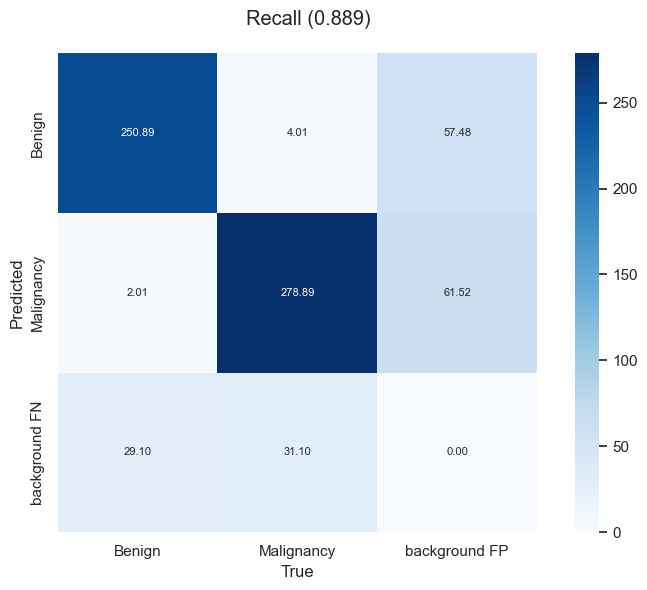

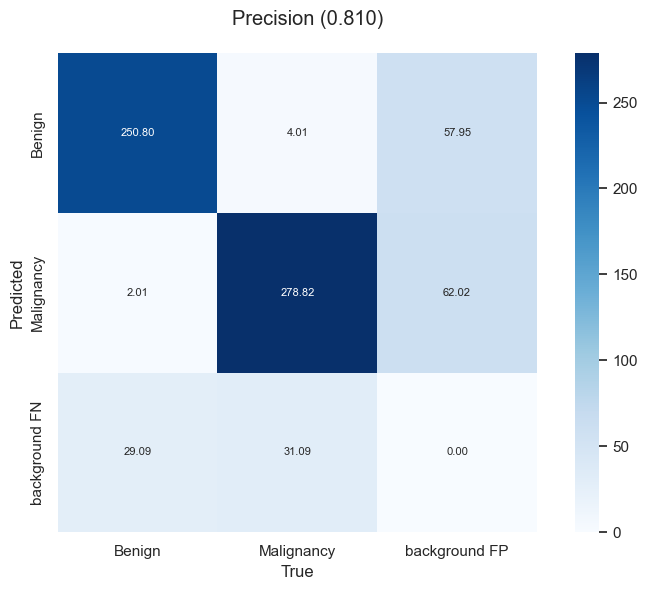

In [21]:
#STAGE_CNT = 60
#from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, output_dir="./output")
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

#### Nodule Per Image = 1

In [22]:
cfg.TEST.DETECTIONS_PER_IMAGE=1

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/05 01:49:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron_lung_aug\faster_rcnn_R_101_FPN_3x\2023-12-04-00-30-39\model_final.pth ...


In [ ]:
dataset_valid = DatasetCatalog.get(TEST_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    im2 = out.get_image()[:, :, ::-1]
    plt.imshow(im2)
    plt.show()

WARNING [12/05 01:55:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[0, 1]
{0: 0, 1: 1}
[12/05 01:55:17 d2.data.datasets.coco]: Loaded 789 images in COCO format from E:/LUNA/Autolabel/1126/yolo_lung_aug\test\_annotations_lung_aug.json
[12/05 01:55:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/05 01:55:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/05 01:55:17 d2.data.common]: Serializing 789 elements to byte tensors and concatenating them all ...
[12/05 01:55:17 d2.data.common]: Serialized dataset takes 0.27 MiB
[12/05 01:55:17 d2.evaluation.evaluator]: Start inference on 789 batches


[12/05 01:55:21 d2.evaluation.evaluator]: Inference done 11/789. Dataloading: 0.0005 s/iter. Inference: 0.0397 s/iter. Eval: 0.0002 s/iter. Total: 0.0404 s/iter. ETA=0:00:31
[12/05 01:55:26 d2.evaluation.evaluator]: Inference done 127/789. Dataloading: 0.0007 s/iter. Inference: 0.0422 s/iter. Eval: 0.0003 s/iter. Total: 0.0432 s/iter. ETA=0:00:28
[12/05 01:55:31 d2.evaluation.evaluator]: Inference done 246/789. Dataloading: 0.0007 s/iter. Inference: 0.0415 s/iter. Eval: 0.0003 s/iter. Total: 0.0426 s/iter. ETA=0:00:23
[12/05 01:55:36 d2.evaluation.evaluator]: Inference done 365/789. Dataloading: 0.0007 s/iter. Inference: 0.0414 s/iter. Eval: 0.0003 s/iter. Total: 0.0424 s/iter. ETA=0:00:17
[12/05 01:55:41 d2.evaluation.evaluator]: Inference done 481/789. Dataloading: 0.0007 s/iter. Inference: 0.0415 s/iter. Eval: 0.0003 s/iter. Total: 0.0426 s/iter. ETA=0:00:13
[12/05 01:55:46 d2.evaluation.evaluator]: Inference done 601/789. Dataloading: 0.0007 s/iter. Inference: 0.0414 s/iter. Eval: 

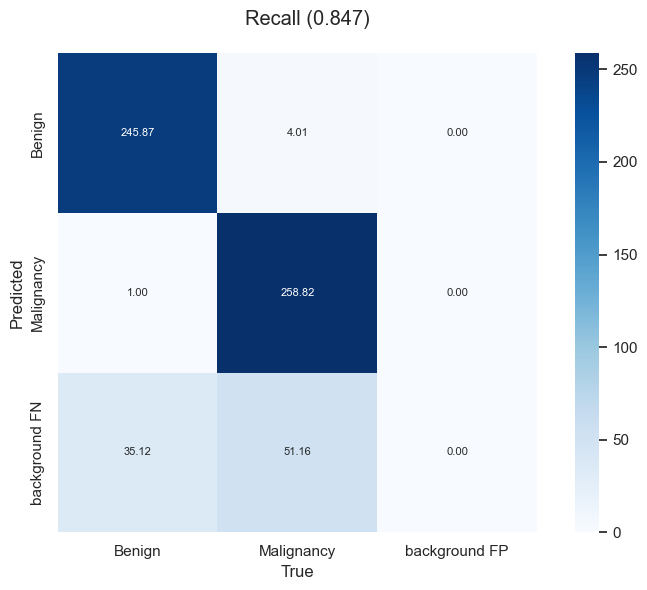

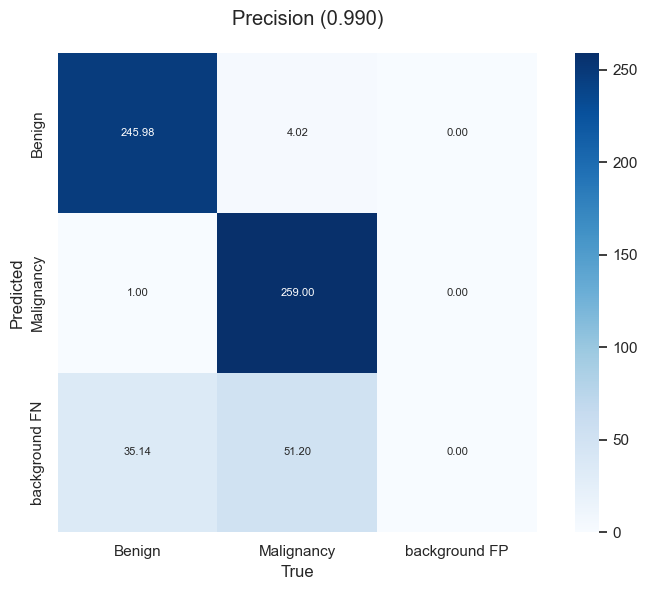

In [25]:
#from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, output_dir="./output")
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [26]:
cfg.TEST.DETECTIONS_PER_IMAGE=2

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/05 01:56:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron_lung_aug\faster_rcnn_R_101_FPN_3x\2023-12-04-00-30-39\model_final.pth ...


In [ ]:
dataset_valid = DatasetCatalog.get(TEST_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    im2 = out.get_image()[:, :, ::-1]
    plt.imshow(im2)
    plt.show()

WARNING [12/05 02:01:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[0, 1]
{0: 0, 1: 1}
[12/05 02:01:41 d2.data.datasets.coco]: Loaded 789 images in COCO format from E:/LUNA/Autolabel/1126/yolo_lung_aug\test\_annotations_lung_aug.json
[12/05 02:01:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/05 02:01:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/05 02:01:41 d2.data.common]: Serializing 789 elements to byte tensors and concatenating them all ...
[12/05 02:01:41 d2.data.common]: Serialized dataset takes 0.27 MiB
[12/05 02:01:41 d2.evaluation.evaluator]: Start inference on 789 batches


[12/05 02:01:45 d2.evaluation.evaluator]: Inference done 11/789. Dataloading: 0.0006 s/iter. Inference: 0.0421 s/iter. Eval: 0.0002 s/iter. Total: 0.0430 s/iter. ETA=0:00:33
[12/05 02:01:50 d2.evaluation.evaluator]: Inference done 127/789. Dataloading: 0.0008 s/iter. Inference: 0.0420 s/iter. Eval: 0.0003 s/iter. Total: 0.0431 s/iter. ETA=0:00:28
[12/05 02:01:55 d2.evaluation.evaluator]: Inference done 244/789. Dataloading: 0.0008 s/iter. Inference: 0.0419 s/iter. Eval: 0.0003 s/iter. Total: 0.0430 s/iter. ETA=0:00:23
[12/05 02:02:00 d2.evaluation.evaluator]: Inference done 363/789. Dataloading: 0.0008 s/iter. Inference: 0.0416 s/iter. Eval: 0.0003 s/iter. Total: 0.0428 s/iter. ETA=0:00:18
[12/05 02:02:05 d2.evaluation.evaluator]: Inference done 481/789. Dataloading: 0.0008 s/iter. Inference: 0.0416 s/iter. Eval: 0.0003 s/iter. Total: 0.0427 s/iter. ETA=0:00:13
[12/05 02:02:10 d2.evaluation.evaluator]: Inference done 601/789. Dataloading: 0.0008 s/iter. Inference: 0.0414 s/iter. Eval: 

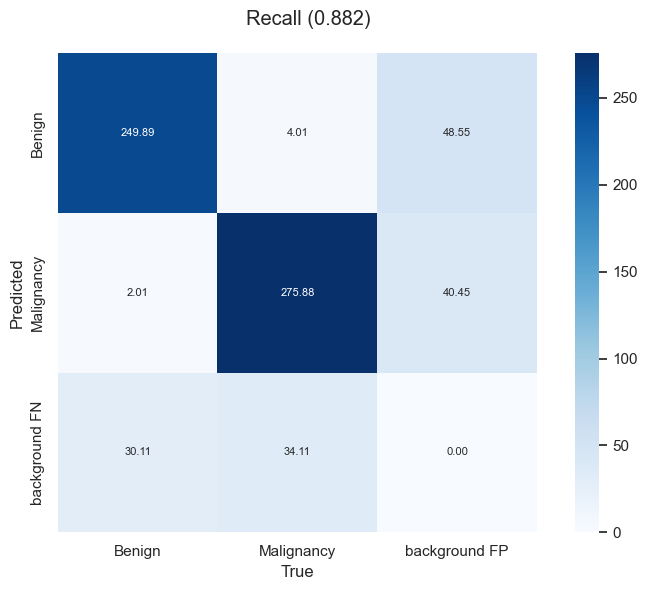

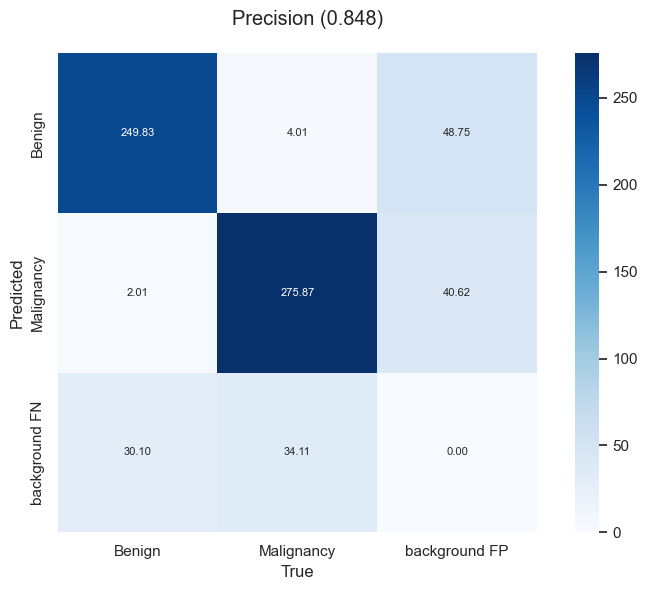

In [29]:
#from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, output_dir="./output")
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`